# Aufgabestellung: 
Der Segelclub Zürichsee beauftragt Sie, für die Clubmitglieder einen Wettermonitor zu bauen. Der Wettermonitor wird neben den Bootsliegeplätzen über einen Bildschirm Wetterdaten für Segler und andere Wassersportler auf hilfreiche Weise darstellen, sodass Segler sie unter anderem zur Planung eines Segeltörns nutzen können. 

Ausserdem sollen Vergleichsdaten aus der Vergangenheit dargestellt werden. Können aus diesen Rückschlüssen auf mögliche Wetter-Entwicklungen gezogen werden, soll das ebenfalls angezeigt werden.

Als Hardware für den Wettermonitor steht ihnen ein Raspberry Pi Computer mit Monitor zur Verfügung. Die Wetterdaten holen Sie sich fortlaufend von einem Webservice der Seepolizei Zürich und speichern sie in einer Datenbank auf dem Raspberry Pi. Die Software soll hauptsächlich in Python programmiert werden.

Wir gehen davon aus, dass später einmal andere Datenquellen angeschlossen werden sollen oder Erfahrungen von Nutzern über die Zeit hinweg zu Änderungswünschen führen. Solche Veränderungen an der Software müssen dann auch Ihnen fremde Programmierer machen können.

Quelle: [DS_Spaces, Challenge Wettermonitor](https://ds-spaces.technik.fhnw.ch/wettermonitor-hs2019/#book)



# Einführung
**Die Folgende Liste gibt an in welchen Kapiteln die verschiedenen Kompetenzen angewandt wurden:**

(Gewisse Kompetenzen wurden auch in anderen Dokumenten als dieses Python-Notebook verwendet. Bitte betreachten Sie auch die anderen Dokumente in der Abgabe)

| Kapitel | eda | wer | git | pgr | gdb | gdv | pko | pra |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 3 |  |  | x |  | x |  |  |  |
| 4 | x |  |  | x |  | x |  |  |
| 5 |  |  |  | x |  | x |  |  |
| 6 |  |  |  | x |  | x |  |  |
| 7 |  | x |  | x |  |  |  |  |
| 8 |  | x |  | x |  |  |  |  |
| 9 |  |  |  | x |  |  |  |  |

**Einführung:**
In diesem Notebook werden wir die Daten der "Wetterstation für Wassersportler-Challenge, HS19C5" untersuchen. Die Idee hinter dem Projekt ist es einen Wettermonitor für Segler zu entwickeln (Daten von der Seepolizei Zürich) welche mit einem Raspberry Pi 4 auf einem Monitor in Form eines Dashboards visualisert werden. Die Challenge selbst finden Sie unter dem folgenden Link: [Wetterstion-Challenge](https://ds-spaces.technik.fhnw.ch/wettermonitor-hs2019/#menu-second)

Dieses Notebook wird verwendet, um die Daten in zahlreichen Plots zu visualisieren. Die Berechnung der Wahrscheinlichkeiten erfolgt ebenfalls in diesem Python-Notebook. Alle anderen Dokumente die bei der Bearbeitung der Challenge erstellt wurden sind im Abgabeordner ersichtlich. Bitte lesen Sie das README.txt-File um einen Überblick zu erhalten.

Prüfen Sie zu Beginn ob alle Libraries auf der lokalen Umgebung installiert sind oder betrachten Sie das Notebook als PDF (In der Abgabe)

In [120]:
import pandas as pd
import pandas_profiling
from csv import reader
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns; sns.set_style("dark")
import matplotlib.pyplot as plt
import missingno
from statsmodels.tsa import seasonal
from math import radians
import datetime
import warnings
import numpy as np
import scipy
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt
from fitter import Fitter
from datetime import timedelta
import plotly as ply
import plotly.graph_objects as go
import chart_studio.plotly as py

# Setup Services
Die Datenbank, welche alle historischen Wetterdaten der Stationen 'Mythenquai' und 'Tiefenbrunnen' enthalten wird, läuft auf einer InfluxDB (Timeseries Datenbank)
Die Daten werden von der API der Seepolizei Zürich heruntergeladen und in der Datenbank gespeichert. Ziel ist es diesen Pull alle 10 Minuten durchzuführen.

#### Installation InfluxDB
Download: [Influx DB, V. 1.7.8](https://portal.influxdata.com/downloads/)

Bearbeitung der Config-Datei:

1. Ordner "data","meta,"val" erstellen
2. Config-File mit den Pfaden der neu erstellten Ordner erweitern

Starten der InfluxDB:

1. Infuxdb.exe starten (Startet die Datenbank)
2. Inluxd.exe starten (Startet das Terminal)
3. Mit `SHOW DATABASES`kann zum Beispiel im Terminal die Datenbanken angezeigt werden. Vor dem erstellen der Wetter-DB ist nur die ___ _internal___ Datenbank zu sehen


# EDA
Der EDA Prozess wird mit dem Einlesen der CSV's begonnen. Zu Beginn arbeitn wir nun ausschliesslich mit den CSV "Messwerte_Mythenquai_2019.csv" & 'Messwerte_Tiefenbrunnen_2019.csv'.

Ziele des EDA-Prozesses:

- Dataset kennen lernen und erste Vermutungen über Zusammenhänge anstellen
- Dataset vorbereiten oder bereinigen damit mit den Daten gearbeitet werden kann (Data Cleansing)
- Besseres Verständnis über die Daten und somit erste Ideen kriegen wie diese Visualisiert werden könnten

In [65]:
#reads mythenquai and tiefenbrunnen Messwerte
myth = pd.read_csv('../data/messwerte_mythenquai_2019.csv') #myth is short for Mythenquai
tief = pd.read_csv('../data/messwerte_tiefenbrunnen_2019.csv') #tief is short for Mythenquai
myth_old = pd.read_csv('../data/messwerte_mythenquai_2007-2018.csv')
tief_old = pd.read_csv('../data/messwerte_tiefenbrunnen_2007-2018.csv')

Pandas Profiling ist eine gute Funktion um einen umfassenden Report zu einem Dataset zu erstellen. Dieser Report gibt erste Hinweise zu möglichen Problemen im Dataset und zum Beispiel auch Informationen zu korrelienden Features. Um allerdings die Grundlagen zu erlernen und auch weiterführende Analysen durchzuführen wird auf die Verwendung der Funktion 'profile_report' verzichtet und der EDA-Prozess mit anderen Mitteln durchgeführt.

In [66]:
#Profiling Function for firsthand data analysis:
#myth.profile_report()

Zu Beginn betrachten wir einen Teil des Datasets und geben die ersten paar Zeilen als Tabelle aus. Im Dataset wird nicht angegeben in Welcher Einheit die, meist numerischen, Daten sind. Diese Information ist in der untenstehenden Tabelle aufgeführt (Quelle: [Wetterstation Seepolizei Zürich](https://www.tecson-data.ch/zurich/mythenquai/index.php))

**Einheiten der Variablen im Mythenquai Dataset**

| Variable | Einheit | 
| --- | --- | 
| timestamp_cet | Format: %YY-%MM%-%DD %HH:%MM:%%SS |  
| air_temperature | °C |  
| barometric_pressure_qfe | hPa |  
| dew_point | °C |  
| global_radiation | W/m² |  
| humidity | % |  
| precipitation | Summe mm |  
| water_temperature | °C |  
| wind_direction | ° |  
| wind_force_avg_10min | bft |  
| wind_gust_max_10min | m/s |  
| wind_speed_avg_10min | m/s |  
| windchill | °C |  

In [67]:
myth.head()

timestamp_cet  air_temperature  barometric_pressure_qfe  \
0  2019-01-07 23:10:00+00:00              3.0                    981.0   
1  2019-01-07 23:20:00+00:00              2.9                    980.9   
2  2019-01-07 23:30:00+00:00              2.8                    980.7   
3  2019-01-07 23:40:00+00:00              2.8                    980.4   
4  2019-01-07 23:50:00+00:00              2.8                    980.3   

   dew_point  global_radiation  humidity  precipitation  water_temperature  \
0        0.1               0.0      81.0            0.0                6.2   
1        0.0               0.0      81.0            0.0                6.2   
2        0.1               0.0      82.0            0.0                6.2   
3        0.2               0.0      83.0            0.0                6.2   
4        0.3               0.0      83.0            0.0                6.2   

   wind_direction  wind_force_avg_10min  wind_gust_max_10min  \
0           273.0                   2.0                  5.3   
1           273.0                   2.0                  4.5   
2           307.0                   2.0                  6.8   
3           290.0                   2.0                  3.3   
4           287.0                   1.0                  3.4   

   wind_speed_avg_10min  windchill  
0                   2.6        0.0  
1                   2.2        0.9  
2                   3.1       -0.2  
3                   1.9        1.2  
4                   1.5        1.8

In [68]:
tief.head()

timestamp_cet  air_temperature  barometric_pressure_qfe  \
0  2019-01-07 23:10:00+00:00              3.3                    981.0   
1  2019-01-07 23:20:00+00:00              3.2                    980.9   
2  2019-01-07 23:30:00+00:00              3.2                    980.7   
3  2019-01-07 23:40:00+00:00              3.2                    980.5   
4  2019-01-07 23:50:00+00:00              3.2                    980.3   

   dew_point  humidity  water_temperature  wind_direction  \
0        0.5      82.0                6.2           177.0   
1        0.3      81.0                6.2           210.0   
2        0.5      82.0                6.2           174.0   
3        0.5      82.0                6.2           101.0   
4        0.6      83.0                6.2            41.0   

   wind_force_avg_10min  wind_gust_max_10min  wind_speed_avg_10min  windchill  
0                   2.0                  3.9                   2.1        1.8  
1                   1.0                  2.6                   1.0        3.1  
2                   1.0                  3.6                   1.0        2.8  
3                   2.0                  4.6                   2.0        1.5  
4                   1.0                  2.4                   1.0        3.1

## Unterschiede im Dataset
Es gibt einige Unterschiede zwischen den beiden Datasets. Welche für den weiteren Prozess relevant sein könnten.

### Unterschiedliche Spalten
Das Dataset 'myth' hat 13 Spalten mit folgenden Namen:

- 'timestamp_cet' 
- 'air_temperature'
- 'barometric_pressure_qfe'
- 'dew_point'
- 'global_radiation'
- 'humidity', 'precipitation'
- 'water_temperature'
- 'wind_direction'
- 'wind_force_avg_10min',
- 'wind_gust_max_10min'
- 'wind_speed_avg_10min'
- 'windchill'

Währenddessen hat das Dataset 'tief' nur 11 Spalten. Die fehlenden sind rot markiert:

- 'timestamp_cet'
- 'air_temperature'
- 'barometric_pressure_qfe'
- 'dew_point'
- 'humidity'
- 'water_temperature'
- 'wind_direction',
- 'wind_force_avg_10min'
- 'wind_gust_max_10min'
- 'wind_speed_avg_10min'
- 'windchill'

Columns die im Dataset tief nicht vorkommen:

- <font color='red'>'global_radiation'</font>
- <font color='red'>'precipitation'</font>

`data.columns` listet die Spalten der Datasets auf.

In [69]:
#Look at Columns in dataset myth
print(len(myth.columns))
myth.columns

13


Index(['timestamp_cet', 'air_temperature', 'barometric_pressure_qfe',
       'dew_point', 'global_radiation', 'humidity', 'precipitation',
       'water_temperature', 'wind_direction', 'wind_force_avg_10min',
       'wind_gust_max_10min', 'wind_speed_avg_10min', 'windchill'],
      dtype='object')

In [70]:
#Look at Columns in dataset tief
print(len(tief.columns))
tief.columns

11


Index(['timestamp_cet', 'air_temperature', 'barometric_pressure_qfe',
       'dew_point', 'humidity', 'water_temperature', 'wind_direction',
       'wind_force_avg_10min', 'wind_gust_max_10min', 'wind_speed_avg_10min',
       'windchill'],
      dtype='object')

Mit Hilfe dieses for-loops geben wir die Spalten aus welche nicht in beiden Datasets vorhanden sind.

In [71]:
#search for the missing columns in the tief.columns dataset
for i in myth.columns:
    if i not in tief.columns:
        print(i)

global_radiation
precipitation


### Generelle Informationen zu beiden Datasets
Betrachten wir nun den Inhalt der Datasets mit der pandas Funktion `info()`. 
Es fällt auf das Alle Spalten die gleiche Anzahl an "non-null" werten haben, welche auch der anzahl Reihen im Dataset entspricht. Das sagt uns das wir keine "missing values" oder Nan-Values haben. Trotzdem prüfen wir das noch in einem späteren Schritt. Hätten wir Spalten mit sehr wenigen non-null Werten im Vergleich zu anderen Spalten müsste man hier in erwägung ziehen diese Spalten für weitere Schritte (zum Beispiel zum erstellen eines Modelles) nicht zu verwenden da sie keine Aussagekraft besitzen. 

Dataset myth:
 Enthält 31'000 Datenpunkte und abgesehen von der Spalte 'timestamp_cet' (object) sind alle Werte vom Typ float64
 
Dataset tief:
 Enthält 30'956 Datenpunkte (etwas weniger als im Dataset myth) und hat ebenfalls von der Spalte 'timestamp_cet' nur Wete vom Typ float 64
 
 (Werden die Datasets aktualisert werden mehr Datenpunkte in den CSVs sein)

In [72]:
#general Information on the dataset myth
myth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31000 entries, 0 to 30999
Data columns (total 13 columns):
timestamp_cet              31000 non-null object
air_temperature            31000 non-null float64
barometric_pressure_qfe    31000 non-null float64
dew_point                  31000 non-null float64
global_radiation           31000 non-null float64
humidity                   31000 non-null float64
precipitation              31000 non-null float64
water_temperature          31000 non-null float64
wind_direction             31000 non-null float64
wind_force_avg_10min       31000 non-null float64
wind_gust_max_10min        31000 non-null float64
wind_speed_avg_10min       31000 non-null float64
windchill                  31000 non-null float64
dtypes: float64(12), object(1)
memory usage: 3.1+ MB


In [73]:
myth.isna().sum()
#it seems that we have no missing values

timestamp_cet              0
air_temperature            0
barometric_pressure_qfe    0
dew_point                  0
global_radiation           0
humidity                   0
precipitation              0
water_temperature          0
wind_direction             0
wind_force_avg_10min       0
wind_gust_max_10min        0
wind_speed_avg_10min       0
windchill                  0
dtype: int64

`data.describe()` gibt statistische Wertde wie Mittelwert, Standardabweichung, Min, Max etc. des Datasets aus

In [74]:
myth.describe()

air_temperature  barometric_pressure_qfe     dew_point  \
count     31000.000000             31000.000000  31000.000000   
mean         12.171845               968.767552      6.620742   
std           8.527882                 7.926322      6.669039   
min          -3.900000               940.300000     -7.900000   
25%           5.300000               964.800000      1.300000   
50%          11.100000               968.900000      5.300000   
75%          18.900000               973.200000     12.500000   
max          37.400000               988.200000     24.600000   

       global_radiation      humidity  precipitation  water_temperature  \
count      31000.000000  31000.000000   31000.000000       31000.000000   
mean         168.785452     71.464903       0.004516          12.639758   
std          251.856516     16.622307       0.107670           7.448872   
min            0.000000     19.000000       0.000000           4.500000   
25%            0.000000     60.000000       0.000000           5.600000   
50%           17.000000     73.000000       0.000000          11.100000   
75%          268.000000     85.000000       0.000000          20.000000   
max         1000.000000    100.000000       9.000000          27.700000   

       wind_direction  wind_force_avg_10min  wind_gust_max_10min  \
count    31000.000000          31000.000000         31000.000000   
mean       162.540806              1.713839             3.973429   
std        111.728429              0.991080             3.066800   
min          0.000000              0.000000             0.000000   
25%         56.000000              1.000000             1.900000   
50%        157.000000              2.000000             3.300000   
75%        279.000000              2.000000             5.400000   
max        360.000000              7.000000            23.500000   

       wind_speed_avg_10min     windchill  
count          31000.000000  31000.000000  
mean               2.121268     10.861097  
std                1.553520      9.162207  
min                0.000000     -7.700000  
25%                1.100000      3.100000  
50%                1.900000      9.500000  
75%                3.000000     18.300000  
max               17.100000     37.600000

In [75]:
#change 'wind_force_avg_10min' to a catogorical value:
myth['wind_force_avg_10min'] = myth['wind_force_avg_10min'].astype('category')
myth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31000 entries, 0 to 30999
Data columns (total 13 columns):
timestamp_cet              31000 non-null object
air_temperature            31000 non-null float64
barometric_pressure_qfe    31000 non-null float64
dew_point                  31000 non-null float64
global_radiation           31000 non-null float64
humidity                   31000 non-null float64
precipitation              31000 non-null float64
water_temperature          31000 non-null float64
wind_direction             31000 non-null float64
wind_force_avg_10min       31000 non-null category
wind_gust_max_10min        31000 non-null float64
wind_speed_avg_10min       31000 non-null float64
windchill                  31000 non-null float64
dtypes: category(1), float64(11), object(1)
memory usage: 2.9+ MB


In [76]:
#general Information on the dataset tief
tief.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30956 entries, 0 to 30955
Data columns (total 11 columns):
timestamp_cet              30956 non-null object
air_temperature            30956 non-null float64
barometric_pressure_qfe    30956 non-null float64
dew_point                  30956 non-null float64
humidity                   30956 non-null float64
water_temperature          30956 non-null float64
wind_direction             30956 non-null float64
wind_force_avg_10min       30956 non-null float64
wind_gust_max_10min        30956 non-null float64
wind_speed_avg_10min       30956 non-null float64
windchill                  30956 non-null float64
dtypes: float64(10), object(1)
memory usage: 2.6+ MB


In [77]:
#change 'wind_force_avg_10min' to a catogorical value:
tief['wind_force_avg_10min'] = tief['wind_force_avg_10min'].astype('category')

In [78]:
tief.describe()

air_temperature  barometric_pressure_qfe     dew_point      humidity  \
count     30956.000000             30956.000000  30956.000000  30956.000000   
mean         12.223107               968.676072      6.496912     70.549877   
std           8.357035                 7.967241      6.606423     16.214369   
min          -3.900000               940.000000     -7.400000     19.000000   
25%           5.400000               964.700000      1.300000     60.000000   
50%          11.100000               968.800000      5.100000     73.000000   
75%          19.000000               973.100000     12.400000     83.000000   
max          35.800000               988.200000     23.400000    100.000000   

       water_temperature  wind_direction  wind_gust_max_10min  \
count       30956.000000    30956.000000         30956.000000   
mean           12.427701      136.554077             2.799121   
std             7.373509      112.611108             3.033580   
min             4.700000        0.000000             0.000000   
25%             5.500000       35.000000             0.700000   
50%            10.600000      126.000000             1.900000   
75%            19.300000      226.000000             3.900000   
max            27.900000      360.000000            22.600000   

       wind_speed_avg_10min     windchill  
count          30956.000000  30956.000000  
mean               1.258551     11.464479  
std                1.656106      8.833900  
min                0.000000     -7.200000  
25%                0.000000      3.900000  
50%                0.700000     10.100000  
75%                1.700000     18.800000  
max               12.600000     35.900000

In [79]:
tief.isna().sum()
#it seems that we have no missing values

timestamp_cet              0
air_temperature            0
barometric_pressure_qfe    0
dew_point                  0
humidity                   0
water_temperature          0
wind_direction             0
wind_force_avg_10min       0
wind_gust_max_10min        0
wind_speed_avg_10min       0
windchill                  0
dtype: int64

Mit der Funktion `data.dropna()` können wir Zeilen oder Spalten mit NA-Werten droppen (entfernen)

In [80]:
%%capture
#just in case I'm going to drop all the rows with missing values
myth.dropna(axis = 'columns')
tief.dropna(axis = 'columns')

Die kleine Funktion `dub()` prüft ob ein Dataset Zeilen doppelt hat und gibt auf diese Frage eine Antwort in Textform aus.

In [81]:
#Check for dublicates:
def dub(data):
    if len(data[data.duplicated()]) > 0:
        print("No. of duplicated entries: ", len(data[data.duplicated()]))
        print(data[data.duplicated(keep=False)].sort_values(by=list(data.columns)).head())
    else:
        print("No duplicated entries found")

In [82]:
dub(myth)

No duplicated entries found


In [83]:
dub(tief)

No duplicated entries found


In [84]:
#code to drop dublicates:
#df.drop_duplicates(inplace=True)

### Verteilungen
In diesem Schritt werden die Verteilungen der einzelnen Variablen im Dataset nebeneinander geplottet.
Um die Verteilungen zu visualisieren wird ein Histogramm verwendet. Für das Dataset myth wird die Farbe Blau verwendet und für das Dataset tief die Farbe Grün.

In [85]:
#select only columns with number-types data
myth_num = myth.select_dtypes(include = ['float64']) 
tief_num = tief.select_dtypes(include = ['float64'])

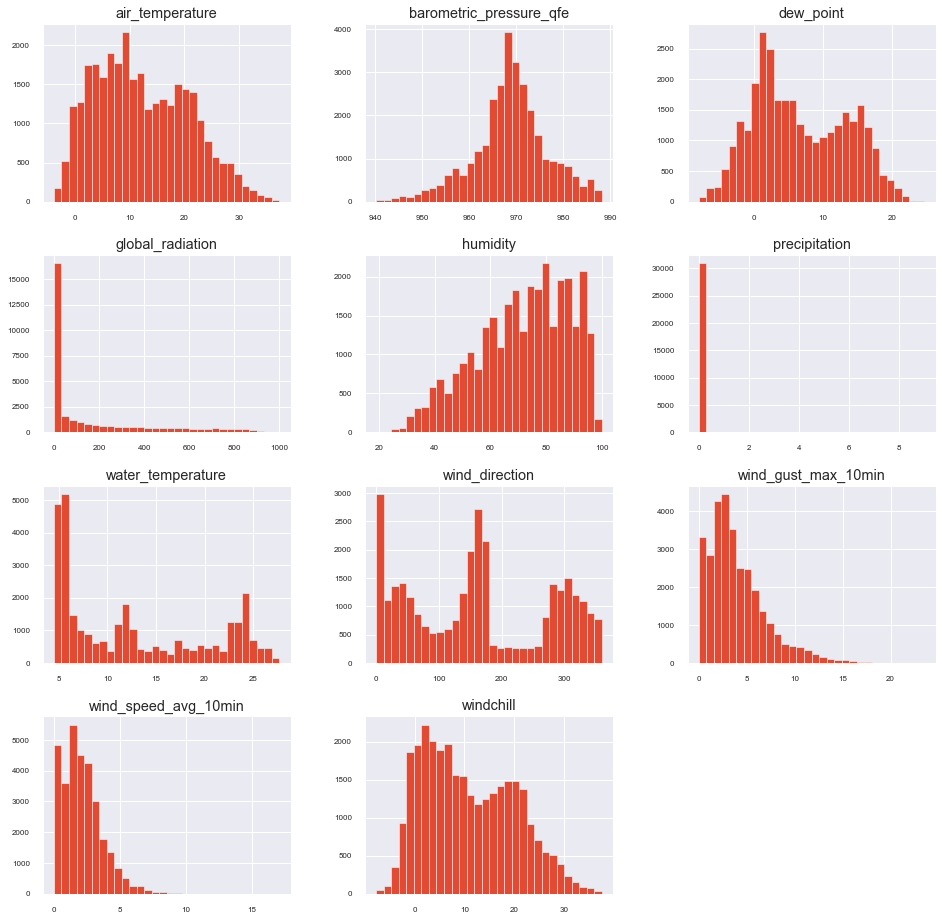

In [86]:
#plot distributions of mythenquai dataset
myth_num.hist(figsize=(16,16), bins=30, xlabelsize = 8, ylabelsize=8);

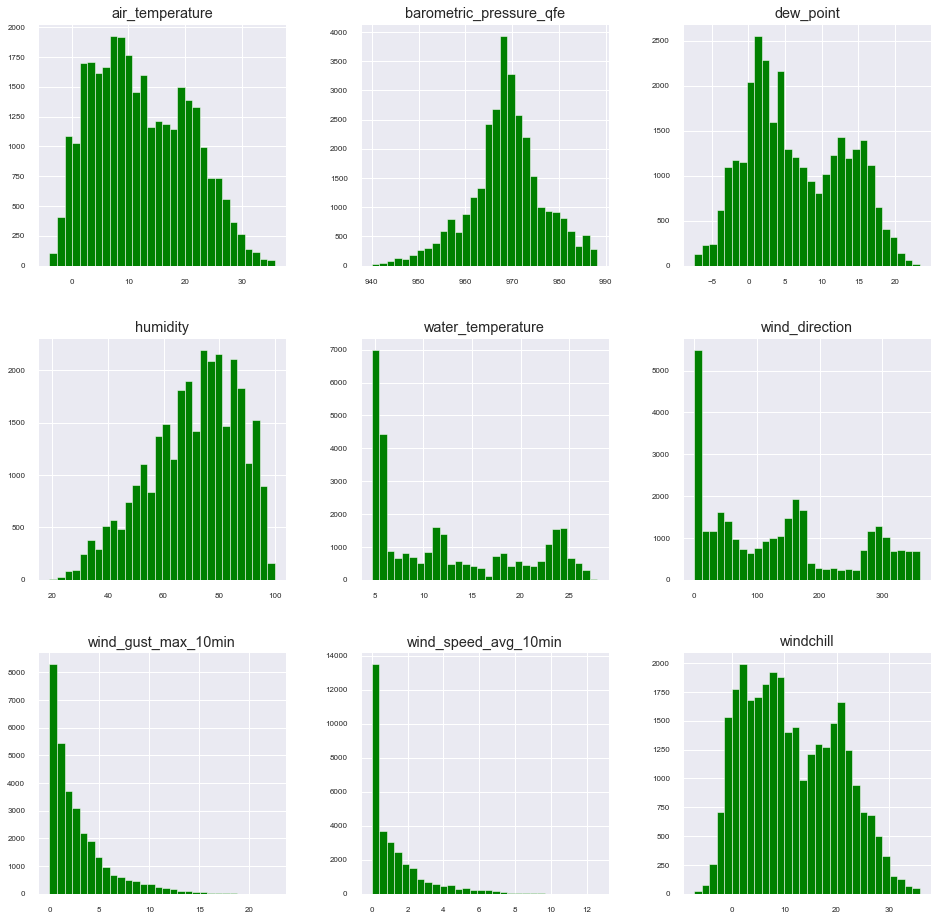

In [87]:
#plot distributions of tiefenbrunnen dataset
tief_num.hist(figsize=(16,16), bins=30, xlabelsize = 8, ylabelsize=8, color = 'green');

### Korrelation testen und visualisieren
Um die Korrelation zu visualisieren wird eine Heatmap verwendet. Je grüner die Farbe umso höher die korrelation. Um die Korrelationen besser unterscheiden zu können werden weisse Linien gezogen um die Kacheln etwas lesbarer zu machen.

Die Korrelation wird mit der Methode 'Pearson' berechnet. (Alternativen wären hier Kendall oder Spearman)

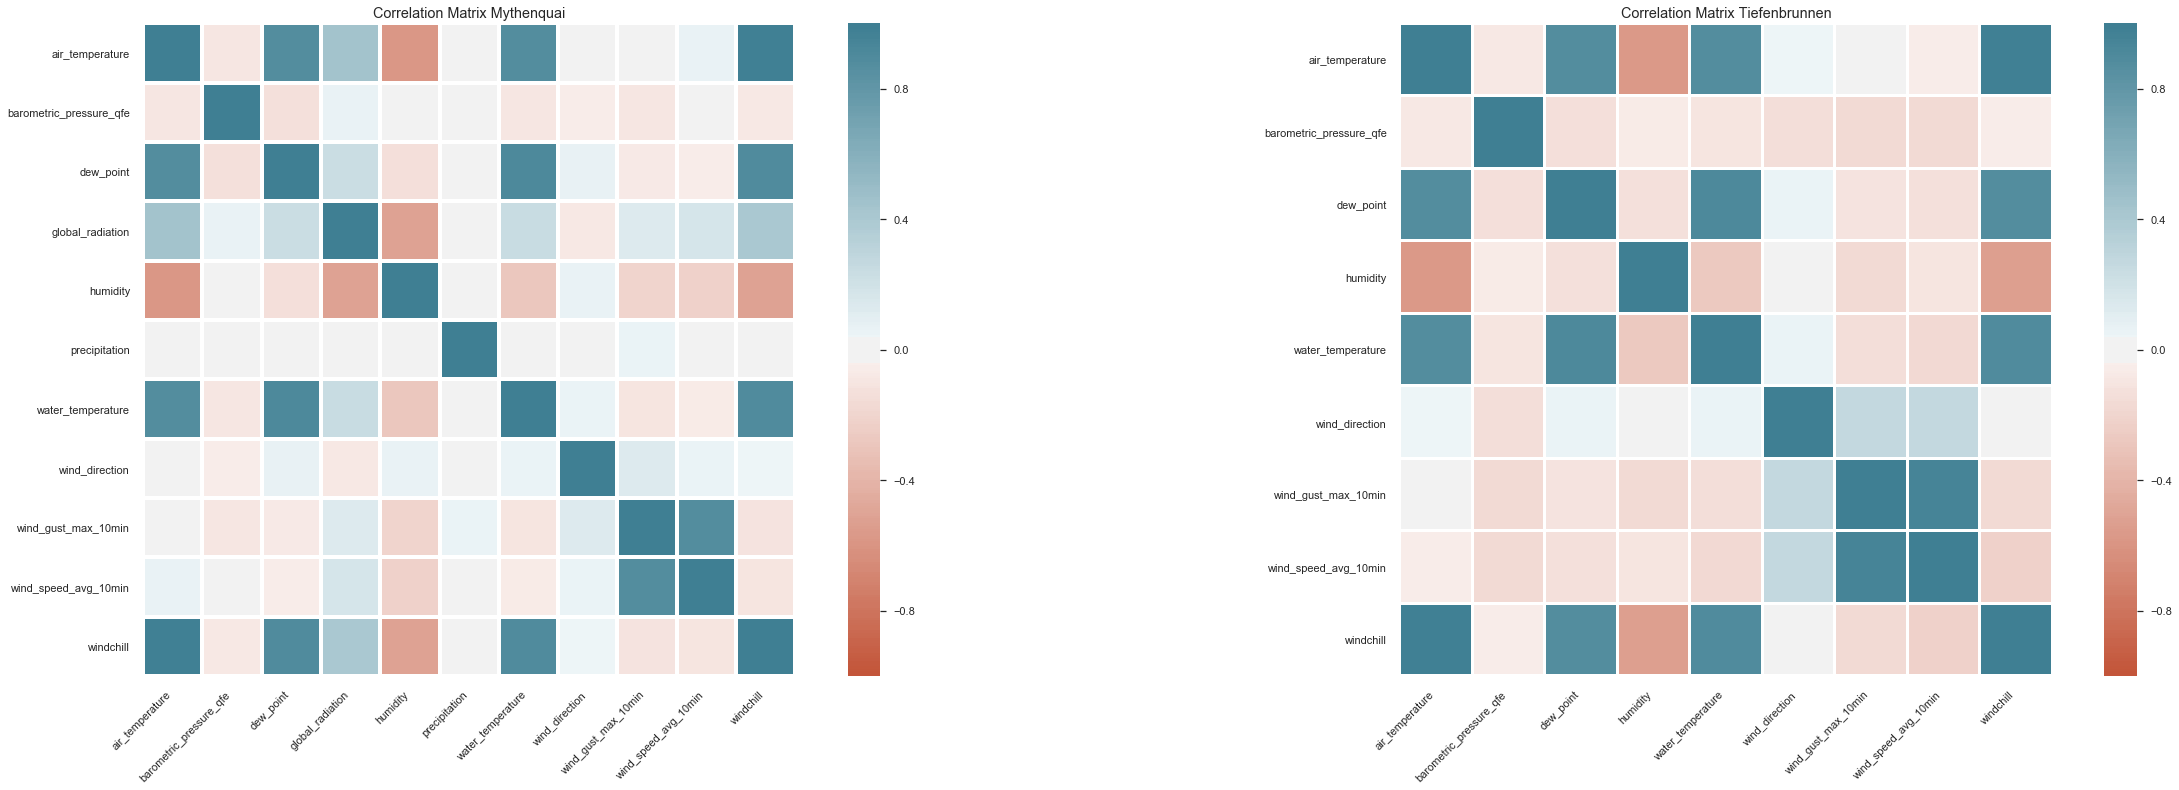

In [88]:
#Correlation Matrix Mythenquai
#create correlation between columns and create heatmap
data = myth
data_2 = tief
corr = data.corr()
corr_2 = data_2.corr()


plt.subplot(1,2,1)
plt.title('Correlation Matrix Mythenquai')
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    linewidths=3,
    
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.subplot(1,2,2)
plt.title('Correlation Matrix Tiefenbrunnen')
ax = sns.heatmap(
    corr_2, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    linewidths=2,
    
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
plt.subplots_adjust(right = 3, left =1)
plt.show()

In [89]:
corr_2

air_temperature  barometric_pressure_qfe  dew_point  \
air_temperature                 1.000000                -0.085214   0.876383   
barometric_pressure_qfe        -0.085214                 1.000000  -0.134457   
dew_point                       0.876383                -0.134457   1.000000   
humidity                       -0.573911                -0.063765  -0.119335   
water_temperature               0.877100                -0.103519   0.909265   
wind_direction                  0.043967                -0.141961   0.053847   
wind_gust_max_10min            -0.013777                -0.158008  -0.109492   
wind_speed_avg_10min           -0.060473                -0.161574  -0.128796   
windchill                       0.983658                -0.058479   0.877743   

                         humidity  water_temperature  wind_direction  \
air_temperature         -0.573911           0.877100        0.043967   
barometric_pressure_qfe -0.063765          -0.103519       -0.141961   
dew_point               -0.119335           0.909265        0.053847   
humidity                 1.000000          -0.269357       -0.004349   
water_temperature       -0.269357           1.000000        0.047802   
wind_direction          -0.004349           0.047802        1.000000   
wind_gust_max_10min     -0.166038          -0.146558        0.276017   
wind_speed_avg_10min    -0.104020          -0.174137        0.267545   
windchill               -0.535540           0.887883        0.014807   

                         wind_gust_max_10min  wind_speed_avg_10min  windchill  
air_temperature                    -0.013777             -0.060473   0.983658  
barometric_pressure_qfe            -0.158008             -0.161574  -0.058479  
dew_point                          -0.109492             -0.128796   0.877743  
humidity                           -0.166038             -0.104020  -0.535540  
water_temperature                  -0.146558             -0.174137   0.887883  
wind_direction                      0.276017              0.267545   0.014807  
wind_gust_max_10min                 1.000000              0.951553  -0.171856  
wind_speed_avg_10min                0.951553              1.000000  -0.225455  
windchill                          -0.171856             -0.225455   1.000000

Die Correlation Matrix zeigt uns welche Variablen zueinander korrelieren. Diese Information ist wichtig da wir damit auf diese Variablen Rückschlüsse ziehen können, welche verwendet werden um eine Voraussage auf den weiteren Wetterverlauf zu prognostizieren.

### Wind
Mit hilfe der Funktion `plot_wind` können wir den Zusammenhang zwischen den Variablen 'wind_speed_avg_10min', 'wind_force_avg_10min' und 'wind_gust_max_10min' visuell darstellen. (Die Plots sind interaktiv)

In [90]:
def plot_wind():
    name = 0
    stations_name = ['myth_old', 'myth', 'tief_old', 'tief']
    stations = [myth_old ,myth, tief_old, tief]
    for station in stations:
        x=station["timestamp_cet"][0:144]
        y0=station["wind_speed_avg_10min"][0:144]
        y1=station["wind_force_avg_10min"][0:144]
        y2=station["wind_gust_max_10min"][0:144]


        fig = go.Figure()

        fig.add_trace(go.Scatter(x=x, y=y1,
                            mode='lines',
                            name='wind force', 
                            marker=dict(color="rgb(67,67,67)")))
        fig.add_trace(go.Bar(x=x, y=y0,
                            name='avg wind speed',
                            marker=dict(color="rgb(50,205,50)")))
        fig.add_trace(go.Bar(x=x, y=y2,
                            name='max wind gust',
                            marker=dict(color="rgb(00,240,240)")))


        fig.update_layout(barmode='stack', title=('Wind over 24h, Station: {}'.format(stations_name[name])))
        fig.show()
        name += 1

In [91]:
plot_wind();

Hier ist die Korrelation zwischen den 3 Attributen sehr gut erkennbar. Steigten die Windböhen, ist auch die durchschnittliche Windgeschwindigkeit und entsprechend auch die Windstärke höher.

Die selbe Funktion haben wir (leicht abgeändert) auf die Lufttemperatur verwendet um den Zusammenhang zwischen Windgeschwindigkeit und Temperatur/gefühlte Temperatur darzustellen.

In [92]:
def plot_corr_temp():
    name = 0
    stations_name = ['myth_old', 'myth', 'tief_old', 'tief']
    stations = [myth_old ,myth, tief_old, tief]
    for station in stations:
        x=station["timestamp_cet"][0:288]
        y0=station["air_temperature"][0:288]
        y1=station["wind_speed_avg_10min"][0:288]
        y2=station["windchill"][0:288]


        fig = go.Figure()

        fig.add_trace(go.Scatter(x=x, y=y0,
                            mode='lines',
                            name='air temperature', 
                            marker=dict(color="rgb(255,67,67)")))

        fig.add_trace(go.Scatter(x=x, y=y1,
                            mode='lines',
                            name='avg wind speed', 
                            marker=dict(color="rgb(67,255,67)")))

        fig.add_trace(go.Scatter(x=x, y=y2,
                            mode='lines',
                            name='windchill', 
                            marker=dict(color="rgb(67,67,255)")))

        fig.update_layout(barmode='stack', title="Windchill relatet to air temperature and wind speed, Station: {}".format(stations_name[name]))
        fig.show()
        name += 1

In [93]:
plot_corr_temp();

Aus dem Diagramm ist zu erkennen, je höher die durchschnittliche Windgeschwindigkeit, umso niediger ist die gefühlte Lufttemperature im Verhältnis zur gemessenen Lufttemperatur.

## Time series
Da wir mit Time Series Data arbeiten ist es sinnvoll den Verlauf der Daten über einen gewissen Zeitraum zu betrachten und ebenfalls Ausschau auf einen Trendverlauf und Saisonalität zu halten. Dazu plotten wir zuerst für jede numerische Variable einen Line-Plot mit der Zeit als x-Achse. Die Funktion `timeseries()` generiert für uns die Plots in einem Stück.

In [94]:
def timeseries(data, timeframe, color):

    data = data.iloc[timeframe:]
    i = 1
    for columData in data.columns:
        if columData != 'timestamp_cet' and columData != 'global_radiation' and columData != 'precipitation':
            plt.subplot(4,3,i)
            data[columData].plot(color = color)
            i += 1
            plt.title(columData)
    plt.subplots_adjust(right = 6, top = 4)
    plt.show()
    

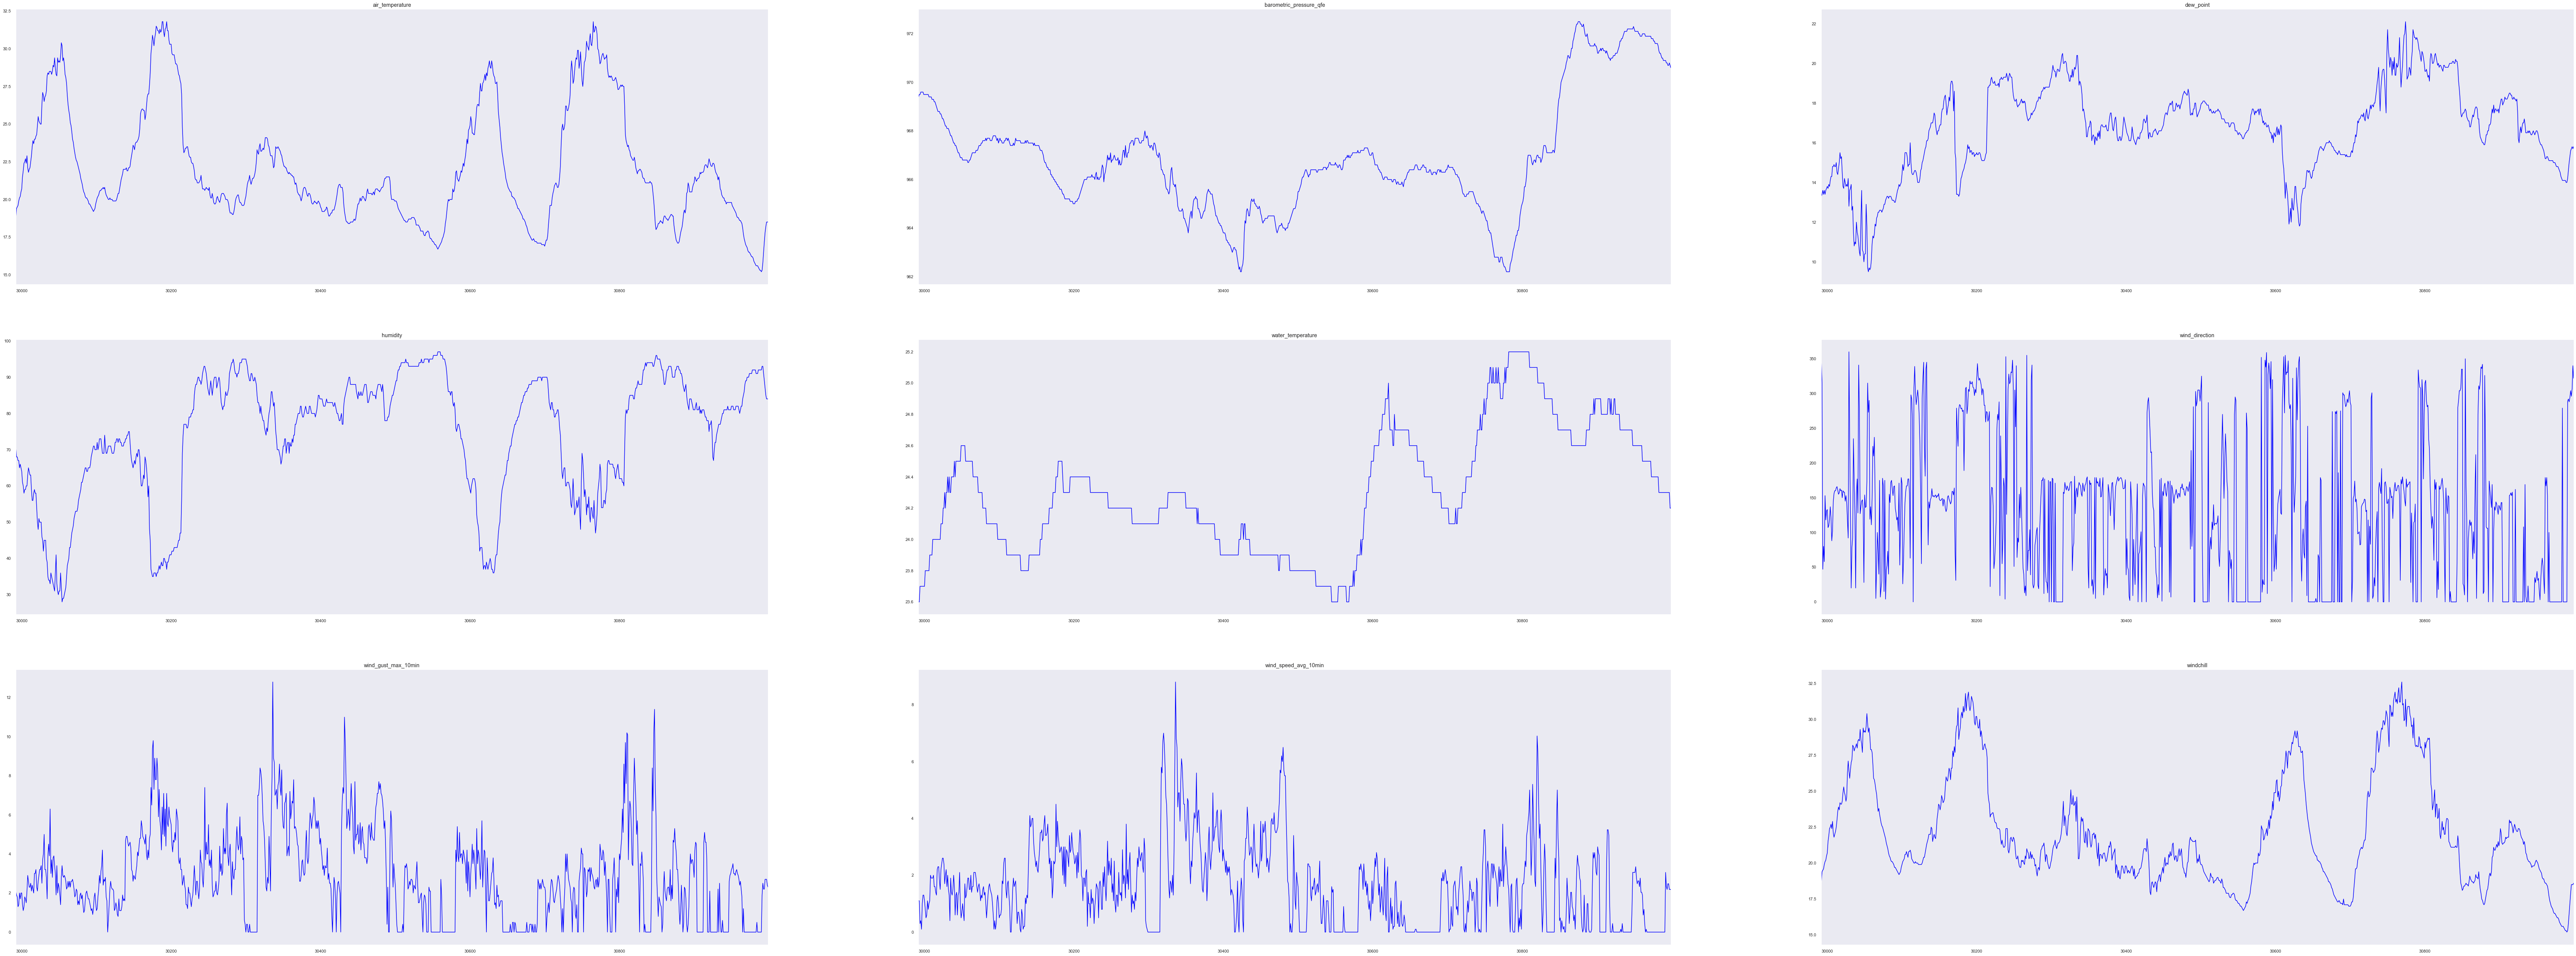

In [95]:
timeseries(myth_num, -1008, 'blue') #one week in the past

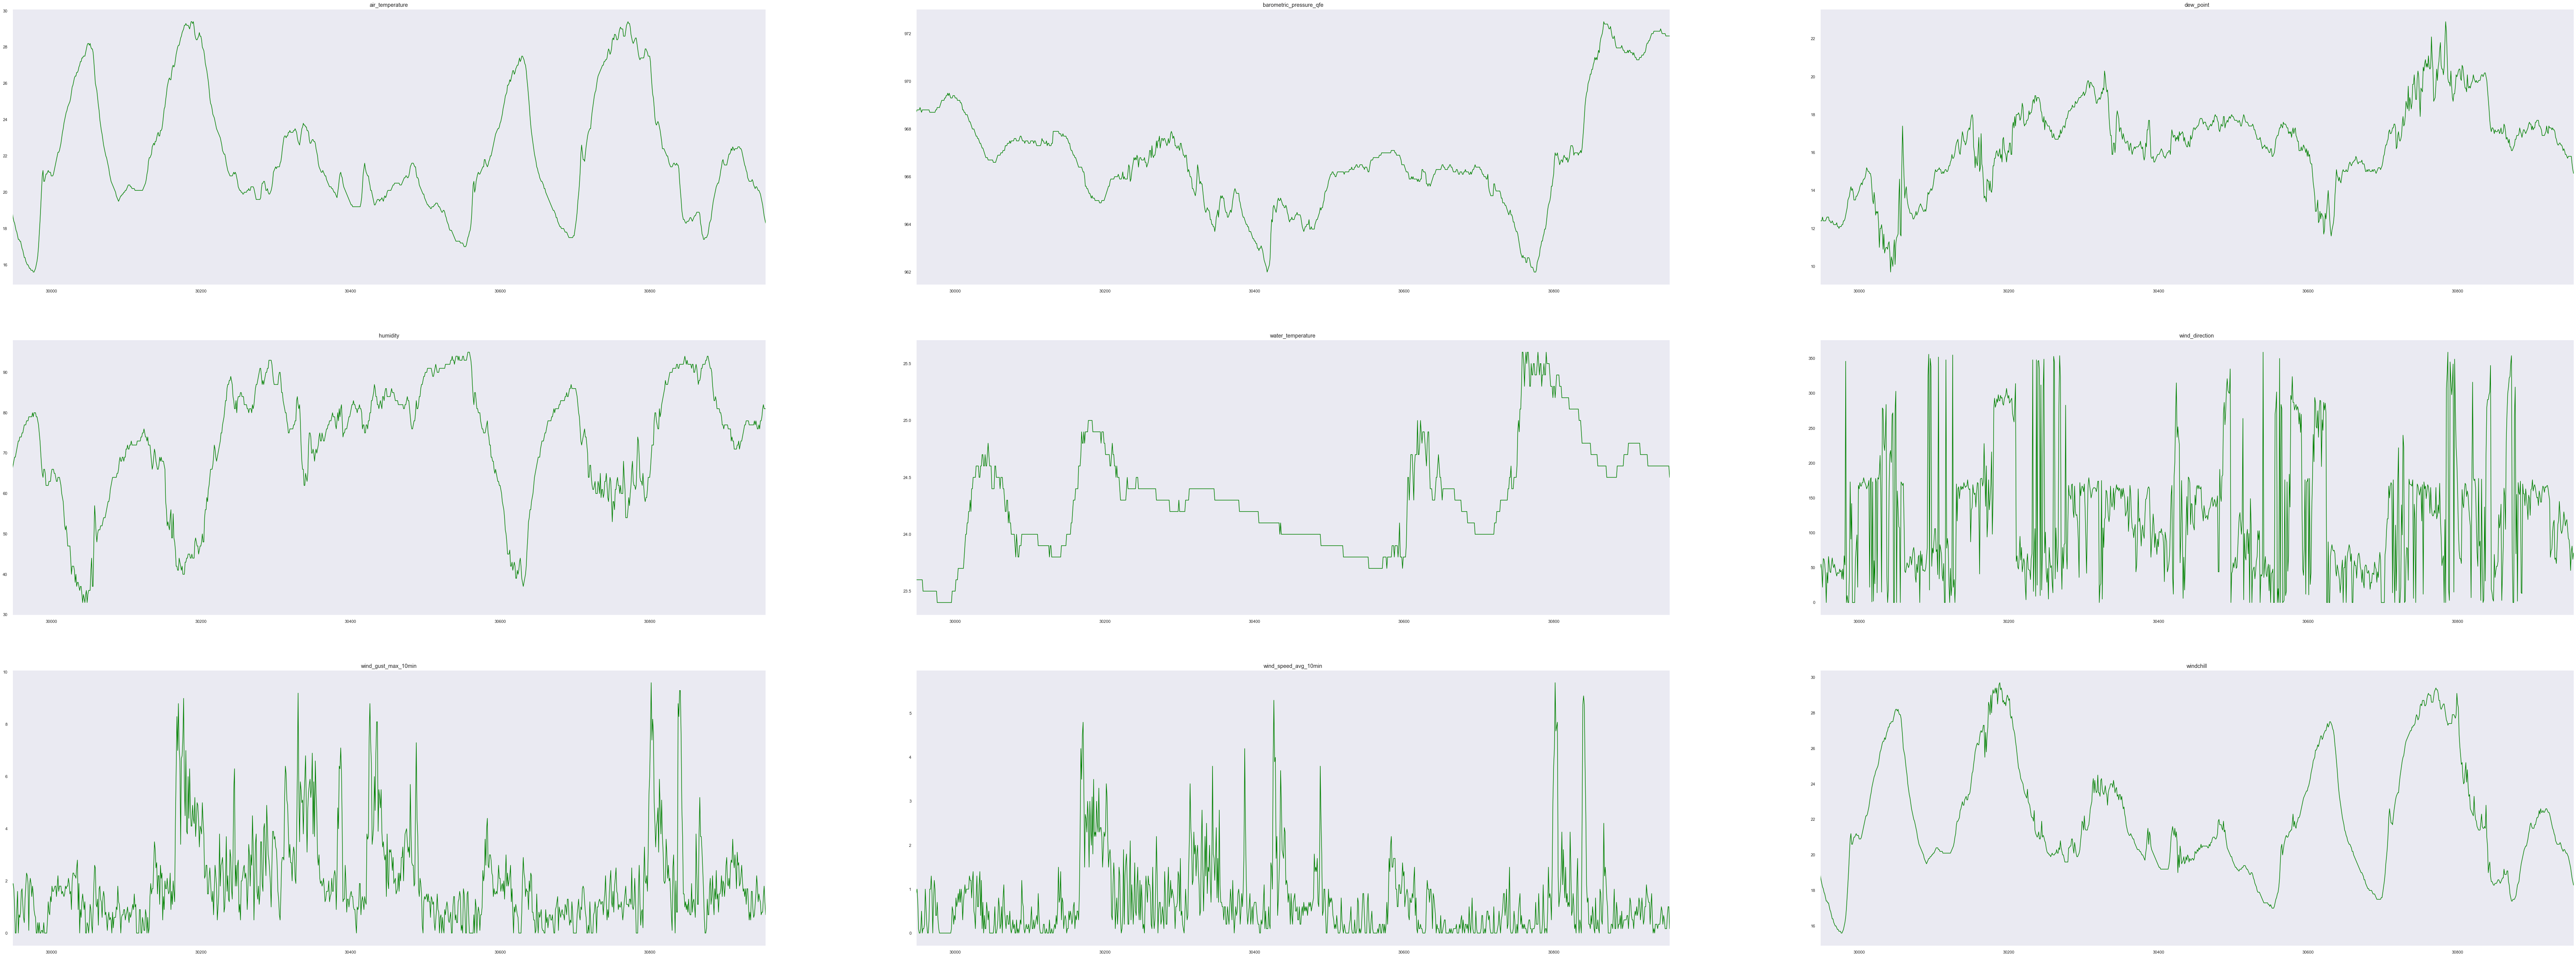

In [96]:
timeseries(tief_num, -1008, 'green') #one week in the past

### Additives Trend-Modell
In der Voraussage des Wetters werden wir zwar keine Prediction mit hilfe eines Additiven Trend-Modell verwenden, es ist aber trotzdem spannend die Daten auf Saisonalität zu prüfen. Variablen wie zum Beispiel die Lufttemperatur werden durch den Tag und durch das Jahr eine Saisonalität aufweisen. Daher plotten wir nun zu jeder Variable ein Additives Trend Model welche die Datan in die Teile Trend, Saisonalität und Residue (Noise) aufteilt. So sollten wir sofort erkennen können ob eine Saisonalität vorhanden ist oder nicht.

In [97]:
def atm(data):
    data = data.iloc[-1008:,:]
    data.timestamp_cet = pd.to_datetime(data.timestamp_cet)
    data = data.set_index(data['timestamp_cet'])
    for columData in data.columns:
        if data[columData].dtype == np.float64:
            y = data[columData].resample('h').sum()
            decomposition = sm.tsa.seasonal_decompose(y, model='additive')
            print('Column: ', columData)
            decomposition.plot()
            plt.show()

C:\Users\Roman Studer\Anaconda3\lib\site-packages\pandas\core\generic.py:5096: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Roman Studer\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



Column:  air_temperature


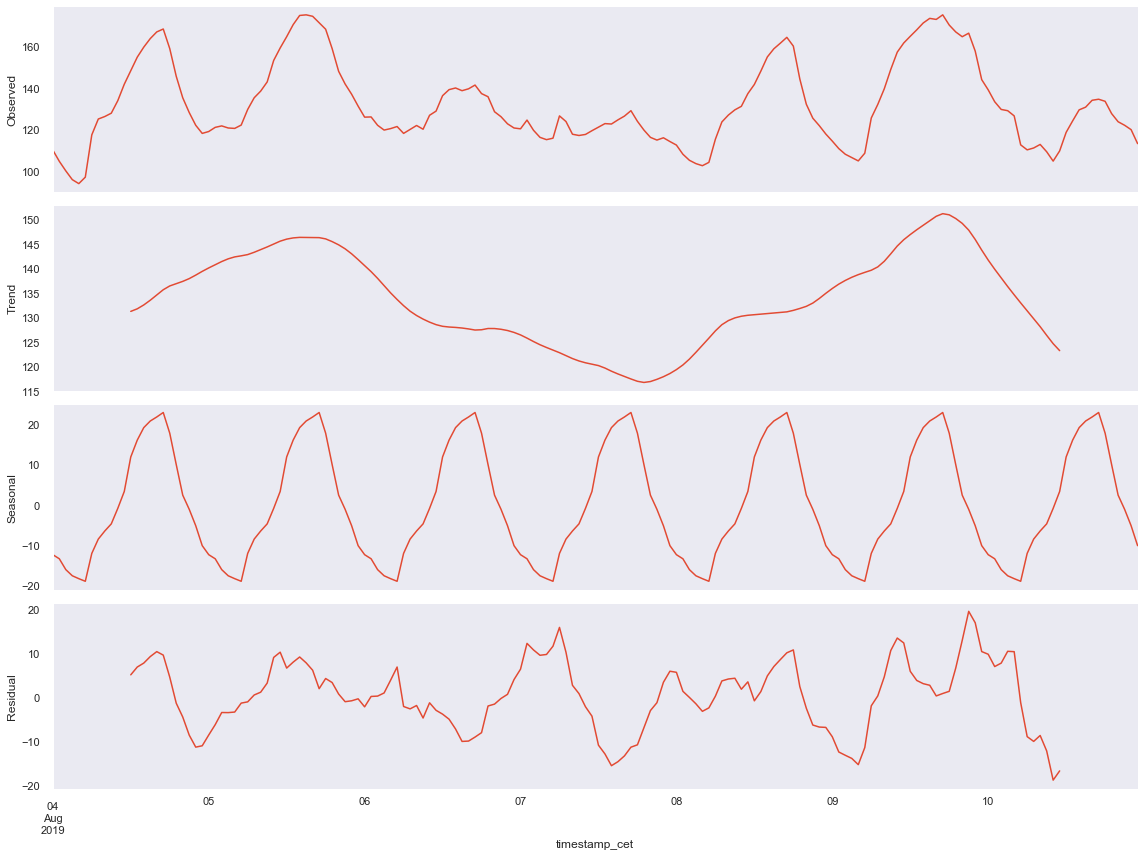

Column:  barometric_pressure_qfe


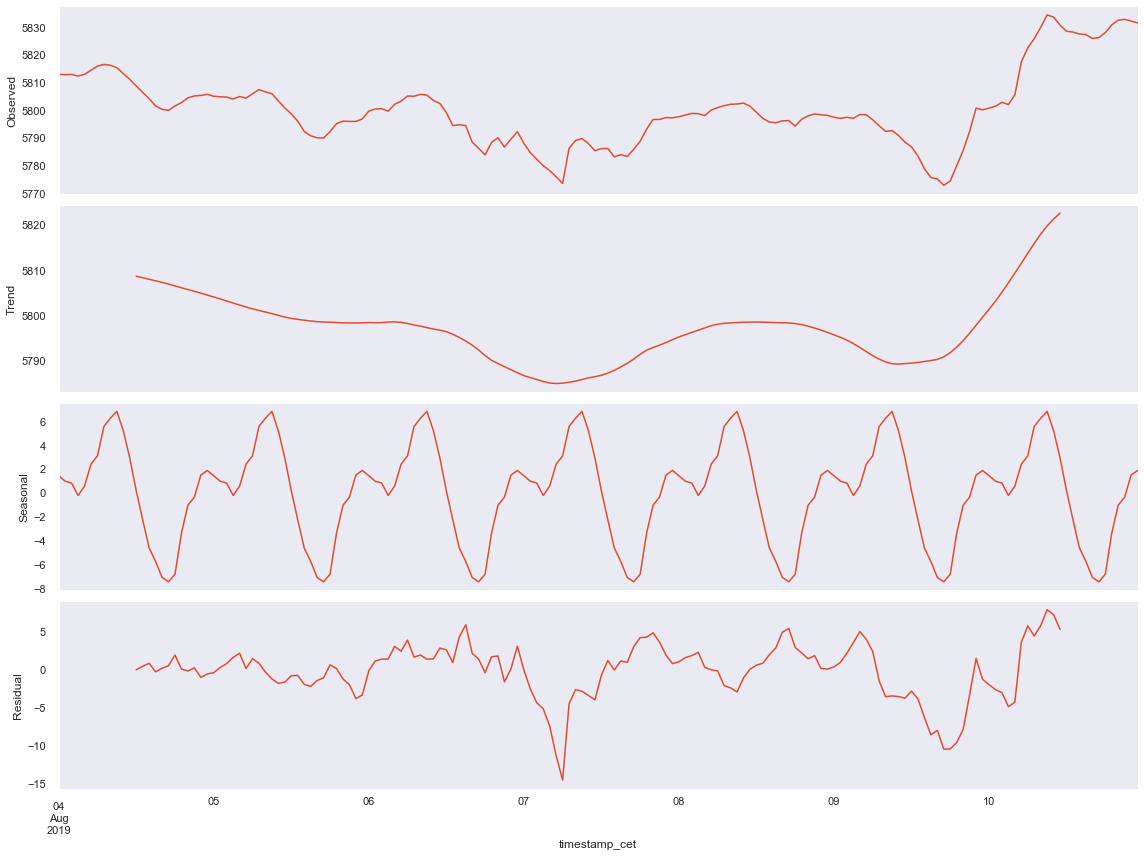

Column:  dew_point


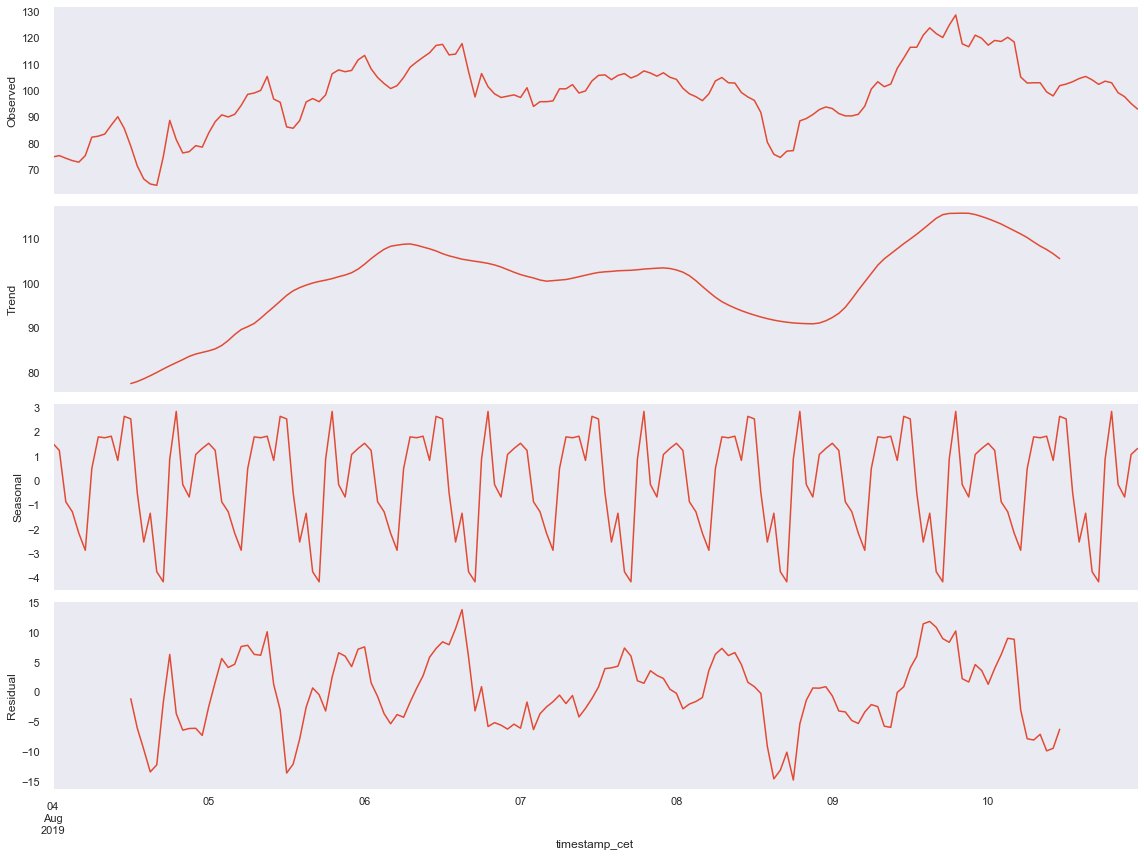

Column:  humidity


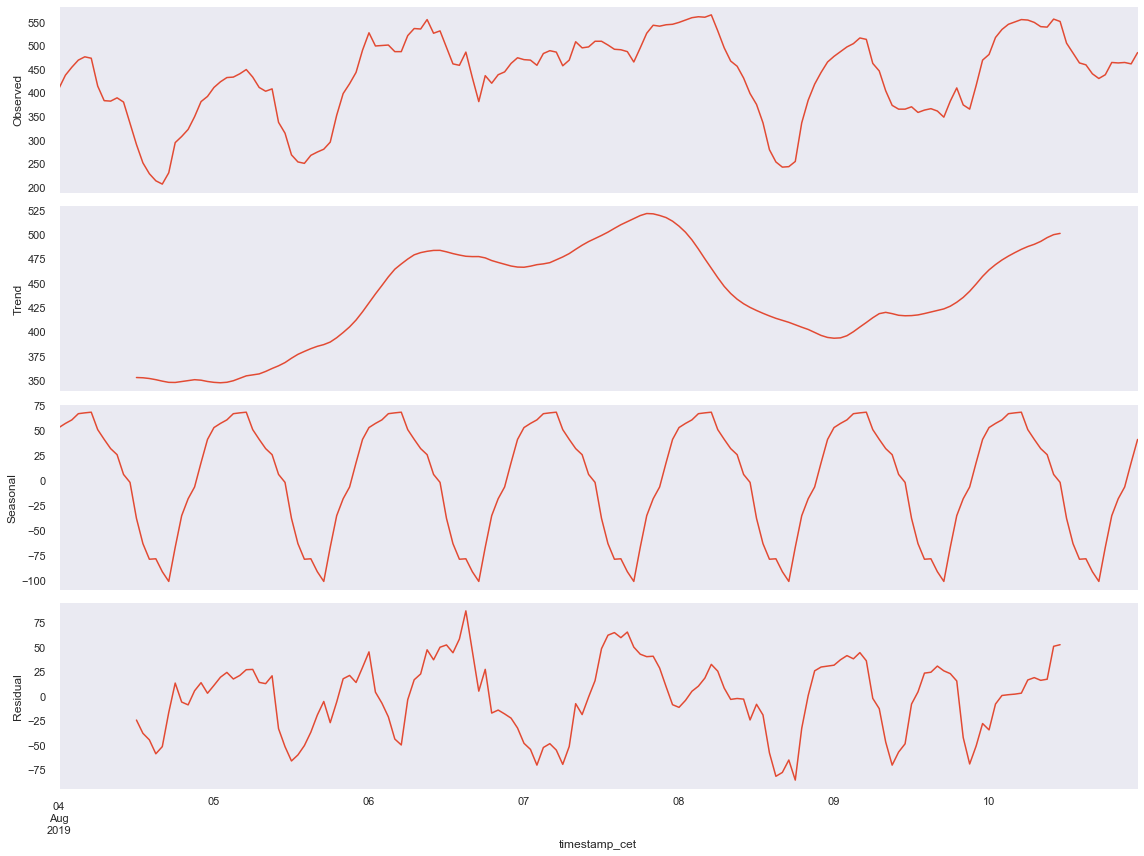

Column:  water_temperature


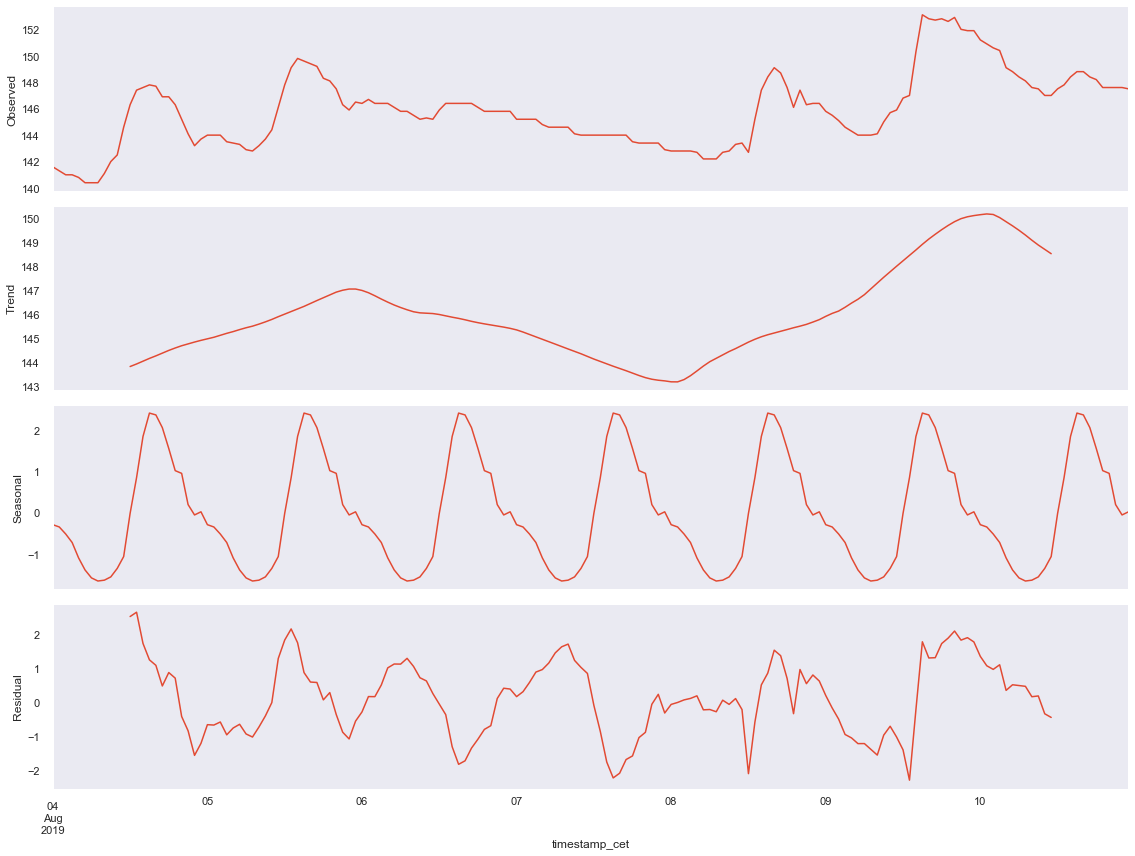

Column:  wind_direction


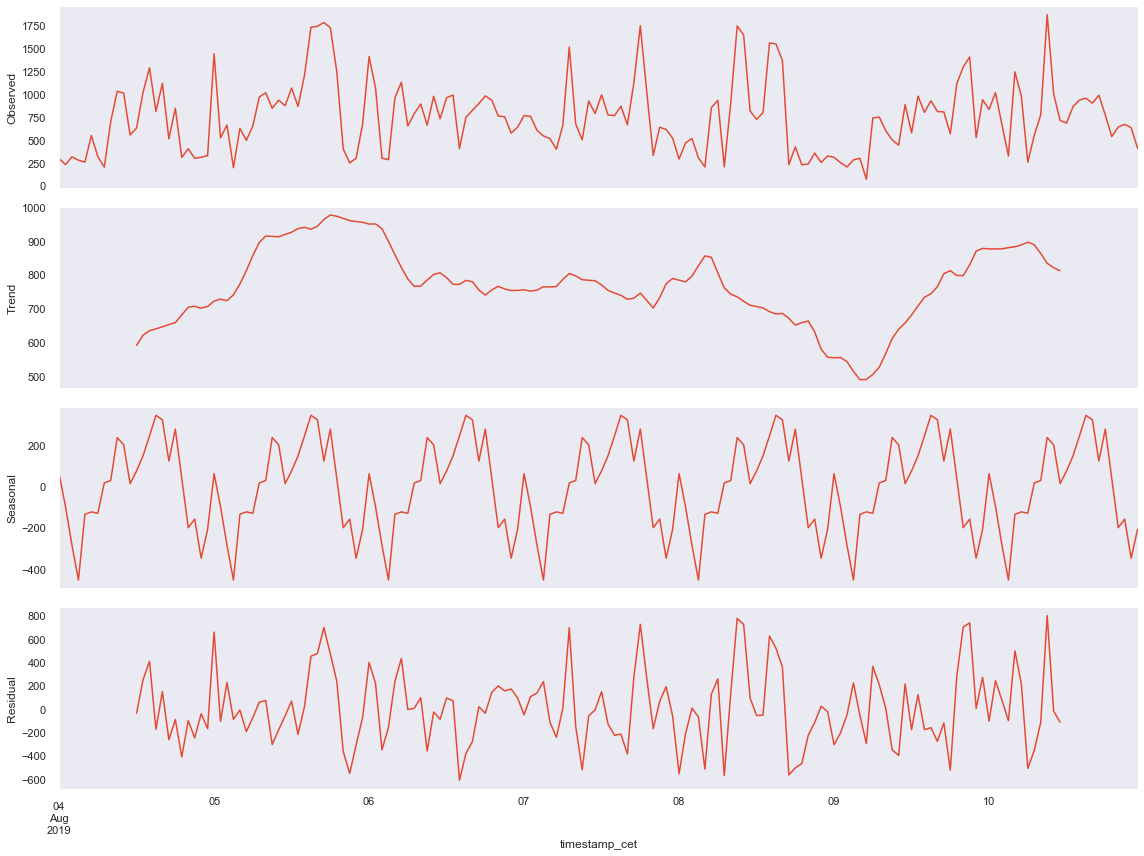

Column:  wind_gust_max_10min


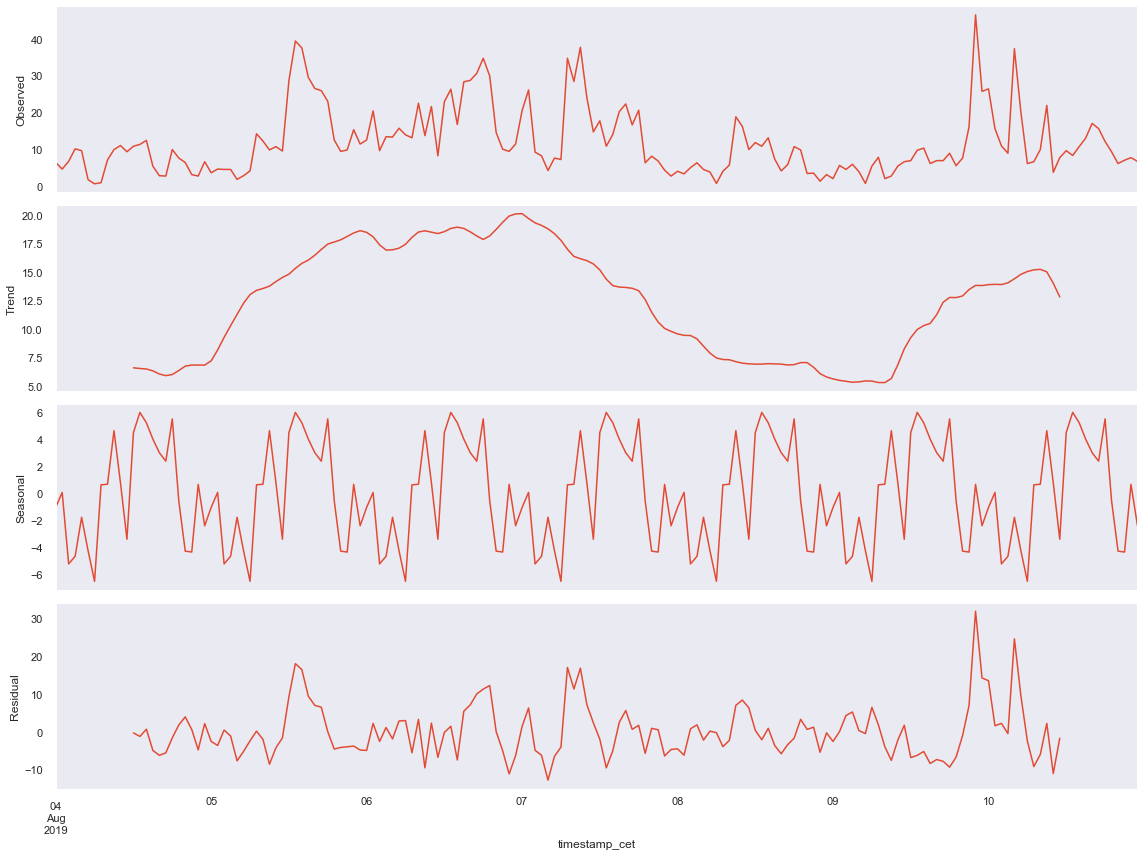

Column:  wind_speed_avg_10min


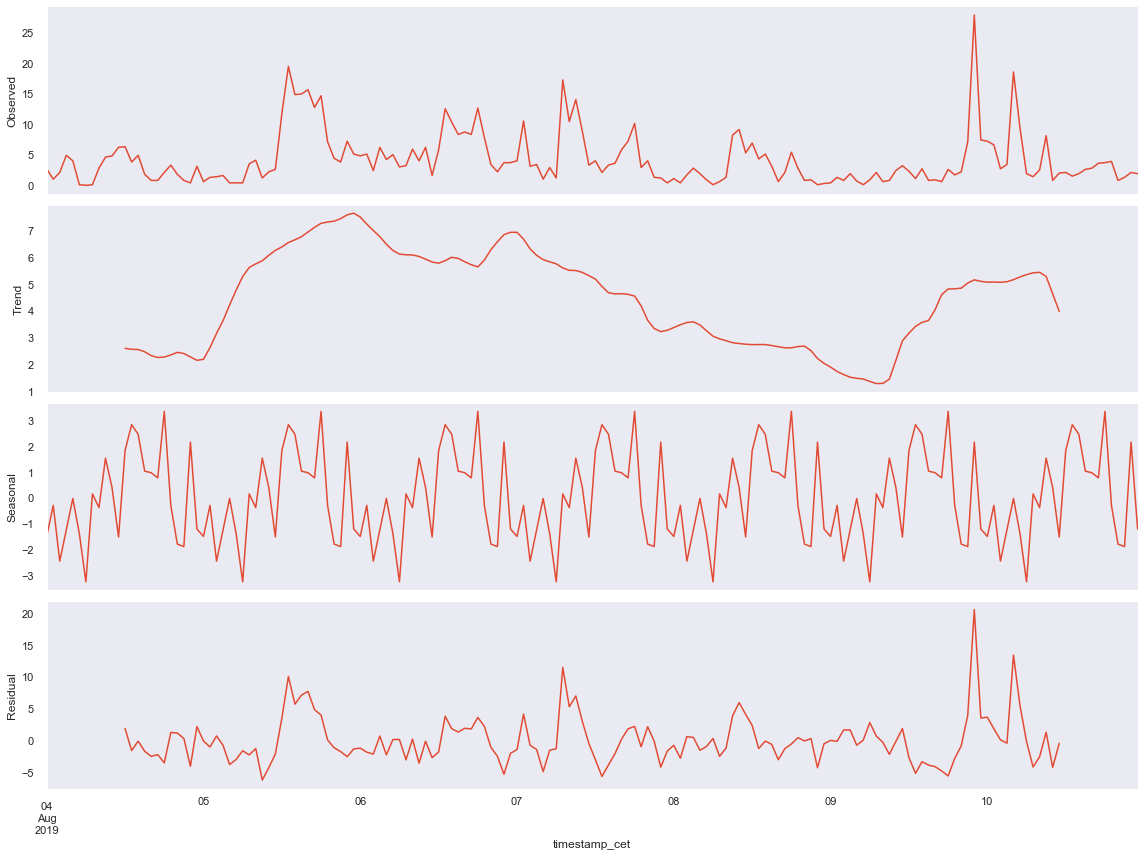

Column:  windchill


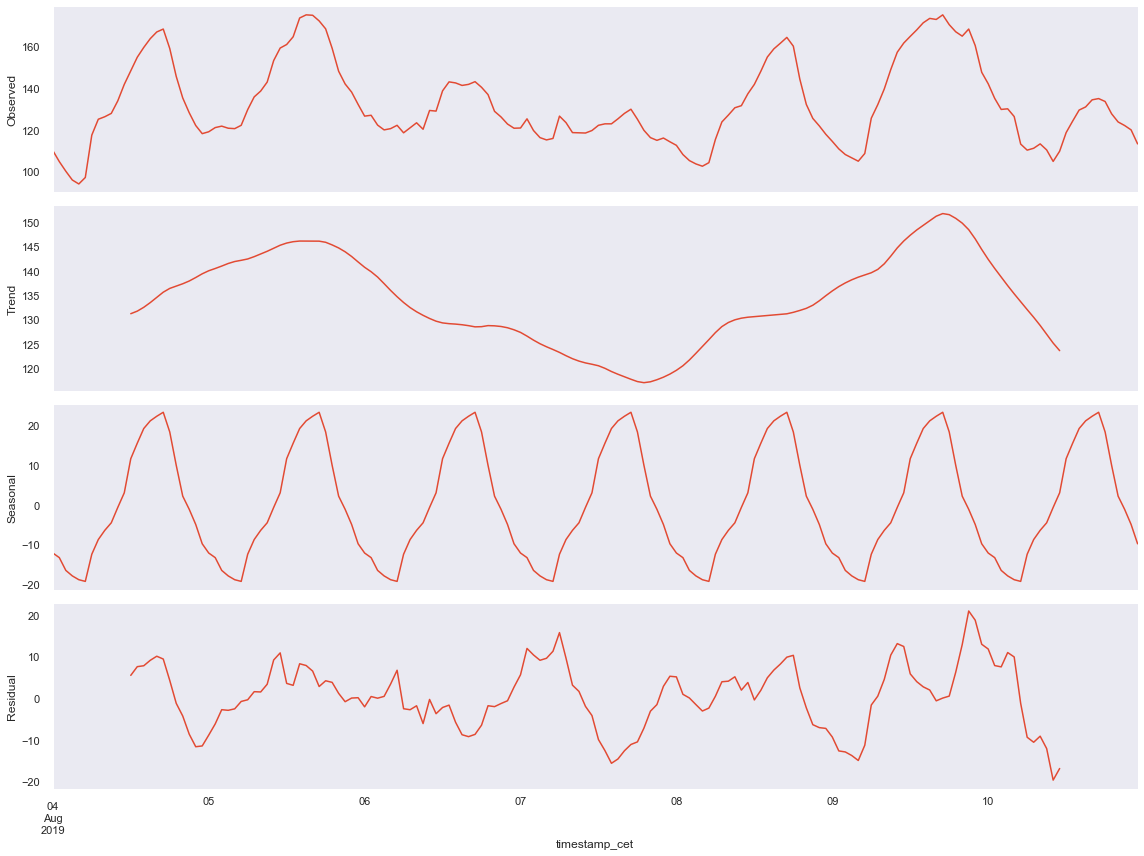

In [98]:
atm(tief);

## Conclusion zum EDA-Prozess
- Das Datenset hat keine Null-Werte und beide Stationen haben fast die gleichen Variablen. Die Variable "global_radiation" ist für uns uninteressant da dieser Wert erstens nur in einem Dataset ernthalten ist und zweitens für unser Ziel nicht wichtig ist. Weiter hat nur ein Datenset die Variable 'percipitation' (engl. für Niederschlag) da die beiden Wetterstationen sehr nahe zusammen sind stellt sich nun die Frage ob diese Variable auch in das zweite Dataset übernommen werden sollte. 

- Die Daten sind alle vom Typ float64. Nur die Variable 'wind_force_avg_10min' ist eine kategorische Variable da es die Beaufortskala darstellt welche die Windstärke in 13 Kategorien (Stärken) aufteilt.

- Es gibt numerische Daten die einer Verteilung folgen könnten (zum Beispiel Lufttemperatur). Dies ist von Vorteil um später eine Vorhersage zu erstellen.

- Weiter sehen wir einen starken zusammenhang zwischen folgenden Variablen:
    - air_temperature & dew_point mit 0.87
    - air_temperature & wateremperatur mit 0.87
    - air_temperature & windchill mit 0.98
    - dew_point & water_temperatur mit 0.91
    - dew_point & windchill mit 0.87
    - water_temperature & windchill mit 0.88
    - alle drei Datenpunkte zum Wind mit plus 0.96

# Datenvisualisierung
Nach dem EDA-Prozess kommt es nun dazu zu entscheiden wie die Daten am besten Visualisert werden sollten. Im Notebook hier zeigen wir nur einen Teil der Visualisierung. Ein komplettes Konzept sowie beschreibung der Entscheidung ist in einem seperaten Dokument ersichtlich. Bitte betrachten Sie dazu den Abgabeordner. Da die beiden Datensets die selben Variablen haben (mit Ausnahme von global_radiation und percipitation) werden die Visualisierungen bei beiden Sets angewandt.

### Windrichtung
Die Windrichtung möchten wir als eine Kompassrose darstellen. Damit hätten wir eine visuelle Darstellung der Windrichtigung. Ähnlich der Anzeige auf einem Instrument. Zum Beispiel im Cockpit eines Flugzeuges.
Weiter sollte die Windrichtung auch als Text in Form von zum Beispiel NNW (Nord-Nord-West) dargestellt werden.

In [99]:
#function to convert winddirection in degree to winddirection as string
# Parameters: takes in a numerical value between 0 and 359
def heading(direction):
    wind = []
    heading = ['N', 'NNO','NO','ONO','O','OSO','SO','SSO','S','SSW','SW','WSW','W','WNW','NW','NNW']
    val = int((direction/22.5)+0.5)
    if val == 16:
        val = 0
    wind.append(heading[val])
    return wind

In [100]:
heading(22.5)

['NNO']

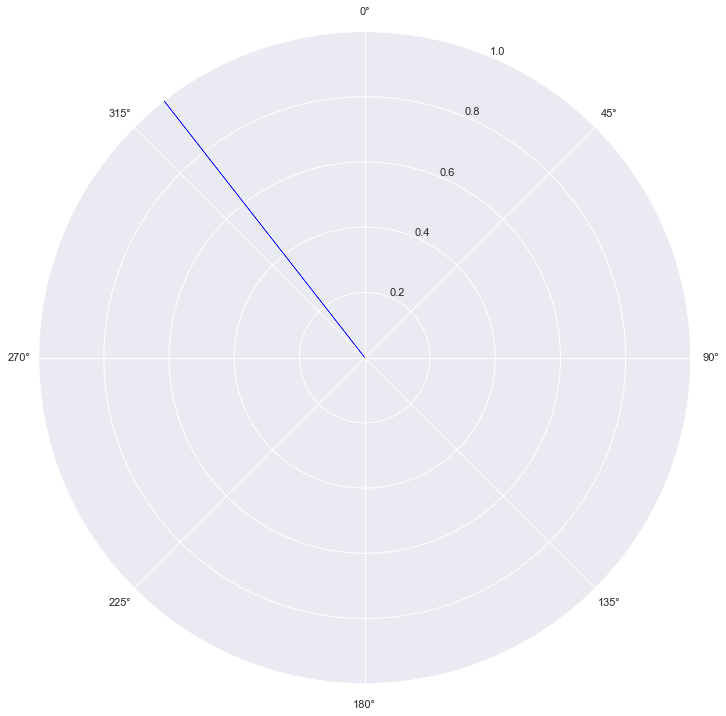

In [101]:
# Use: Plots a line to the corresponding heading of the last wind direction on a polar coordinate system to simulate a compass rose
# Parameters: dataset = Dataset containing a column called 'wind_direction' with a numerical value between 0 and 359
def compass(dataset):
    ax = plt.subplot(111, polar=True)
    ax.arrow(x=0.0,y=0.0,dx=radians(dataset.wind_direction[-1:]), dy=1.0, color = 'blue')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    
compass(myth)

# Daten filtern
Da wir mit einer Timeseries Datenbank arbeiten können wir die Daten nach Datum filtern. Dadurch haben wir die Möglichkeit Vorraussagen anhand der historischen Daten zu erzeugen.

In [102]:
myth.timestamp_cet = pd.to_datetime(myth.timestamp_cet, format = '%Y-%m-%d %H:%M:%S+00:00')
myth_old.timestamp_cet = pd.to_datetime(myth_old.timestamp_cet, infer_datetime_format=True)

In [103]:
myth_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606217 entries, 0 to 606216
Data columns (total 14 columns):
timestamp_cet              606217 non-null datetime64[ns]
air_temperature            606217 non-null float64
water_temperature          606217 non-null float64
wind_gust_max_10min        606217 non-null float64
wind_speed_avg_10min       606217 non-null float64
wind_force_avg_10min       606217 non-null float64
wind_direction             606217 non-null int64
windchill                  606217 non-null float64
barometric_pressure_qfe    606217 non-null float64
precipitation              606217 non-null float64
dew_point                  606217 non-null float64
global_radiation           606217 non-null int64
humidity                   606217 non-null int64
water_level                606217 non-null float64
dtypes: datetime64[ns](1), float64(10), int64(3)
memory usage: 64.8 MB


In [104]:
# Use: Query max, min and mean value of a certain day or for every day of the dataset
# Parameters: data = dataset with a column called 'timestamp_cet', column = name of a column in the dataset, daily = Boolean value (if False: only current day gets used)
def query_max_mean_min(data, column, daily = False):
    now = datetime.datetime.now()
    result = data.set_index(data.timestamp_cet)
    if daily is True:
        result = data[(data['timestamp_cet'].dt.month == now.month) & (data['timestamp_cet'].dt.day == now.day) & (
            data['timestamp_cet'].dt.year == now.year)]
        mean_grouped = result.groupby(by=result['timestamp_cet'].dt.date).mean()
        max_grouped = result.groupby(by=result['timestamp_cet'].dt.date).max()
        min_grouped = result.groupby(by=result['timestamp_cet'].dt.date).min()
    else: 
        mean_grouped = result.groupby(by=result['timestamp_cet'].dt.date).mean()
        max_grouped = result.groupby(by=result['timestamp_cet'].dt.date).max()
        min_grouped = result.groupby(by=result['timestamp_cet'].dt.date).min()

    column_mean = mean_grouped[column]
    column_max = max_grouped[column]
    column_min = min_grouped[column]

    return column_mean, column_max, column_min

In [105]:
query_max_mean_min(myth, 'air_temperature');

In [106]:
# Use: Query a certain hour for every year in the datastet:
# Parameters: data = dataset containing a column 'timestamp_cet' in datetime format
# future_time: adds hours to 'datetime.now()' to query into the 'future'
def query_hist(data, future_time,):
    now = datetime.datetime.now()
    hour = now.hour
    current_day = now.day
    future_hour = hour + 2
    
    if future_hour >=24:
        current_day += 1
        future_hour -= 24
    hist = current_day - 3
    fut = current_day + 3
    result = data[(data['timestamp_cet'].dt.month==now.month) & (data['timestamp_cet'].dt.day==now.day) & (data['timestamp_cet'].dt.hour==(future_hour))]
    return result    

In [107]:
test = query_hist(myth_old, 10)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66 entries, 34546 to 604319
Data columns (total 14 columns):
timestamp_cet              66 non-null datetime64[ns]
air_temperature            66 non-null float64
water_temperature          66 non-null float64
wind_gust_max_10min        66 non-null float64
wind_speed_avg_10min       66 non-null float64
wind_force_avg_10min       66 non-null float64
wind_direction             66 non-null int64
windchill                  66 non-null float64
barometric_pressure_qfe    66 non-null float64
precipitation              66 non-null float64
dew_point                  66 non-null float64
global_radiation           66 non-null int64
humidity                   66 non-null int64
water_level                66 non-null float64
dtypes: datetime64[ns](1), float64(10), int64(3)
memory usage: 7.7 KB


# Sturmwarnungen
Interessant wäre es die Wahrscheinlichkeit zum eintreten einer Starkwind- oder Sturmwarnung zu berechnen. Dazu testen wir zuerst auf welche Verteilung unser Dataset am besten passen könnte. Dazu betrachten wir die Variable wind_gust_max_10min. Da die Warnlichter auf dem See vor Böenspitzen warnen.

**Starkwindwarnung**
Die Starkwindwarnung (orangefarbenes Blinklicht, das pro Minute ungefähr 40 mal aufleuchtet) macht auf die Gefahr des Aufkommens von Winden mit Böenspitzen von 25-33 Knoten (ca. 46-61 km/h) ohne nähere Zeitangabe aufmerksam. (ab 12.7m/s)

	
**Sturmwarnung**
Die Sturmwarnung (orangefarbiges Blinklicht, das pro Minute ungefähr 90 mal aufleuchtet) macht auf die Gefahr des Aufkommens von Winden mit Böenspitzen von über 33 Knoten (ca. 61 km/h) ohne nähere Zeitangabe aufmerksam. (ab 16.9m/s)

In [108]:
#Infos to the wind speed in the dataset:
myth_old.wind_gust_max_10min.describe()

count    606217.000000
mean          3.429065
std           2.601875
min           0.000000
25%           1.700000
50%           2.800000
75%           4.600000
max          32.000000
Name: wind_gust_max_10min, dtype: float64

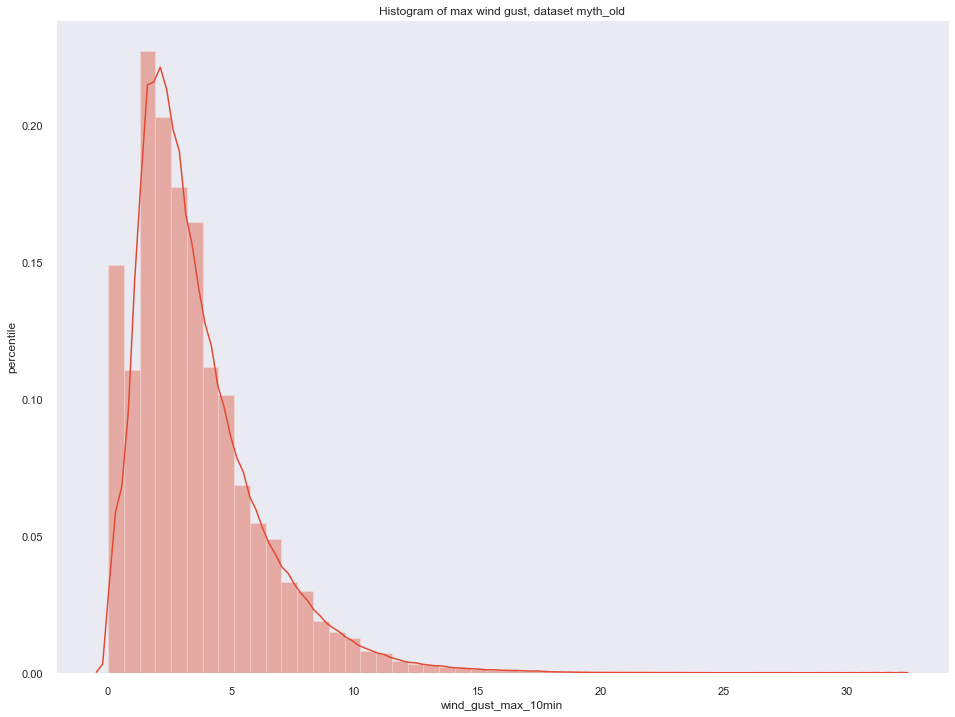

In [46]:
sns.distplot(myth_old.wind_gust_max_10min)
sns.set(rc={'figure.figsize':(8,5)})
plt.ylabel('percentile')
plt.title('Histogram of max wind gust, dataset myth_old')
plt.show()

Die Funktion wind_prob testet die Windgeschwindigkeiten eines Datasets auf seine Verteilung. Und gibt die Wahrscheinlichkeit, dass eine Starkwindwarnung oder Sturmwarnung an diesem Tag auftriff anhand der historischen Daten an.

In [110]:
%matplotlib inline
# Use:  gives out prediction of wind (warings for strong and storm wind) in percent
# Parameters: data = dataset with columns called 'timestamp_cet' and 'wind_gust_max_10min'
def wind_prob(data):
    
    matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
    matplotlib.style.use('ggplot')

    # Create models from data
    def best_fit_distribution(data, bins=200):
        global best_distribution
        """Model data by finding best fit distribution to data"""
        # Get histogram of original data
        y, x = np.histogram(data, bins=bins, density=True)
        x = (x + np.roll(x, -1))[:-1] / 2.0

        # Distributions to check
        DISTRIBUTIONS = [        
            st.dgamma,st.expon,st.exponnorm, st.gamma,st.gengamma,st.invgamma,st.invgauss,
            st.invweibull,st.johnsonsb, st.laplace, st.logistic,st.loggamma,st.loglaplace,
            st.lognorm,st.norm,st.weibull_min,st.weibull_max
        ]

        # Best holders
        best_distribution = st.norm
        best_params = (0.0, 1.0)
        best_sse = np.inf

        # Estimate distribution parameters from data
        for distribution in DISTRIBUTIONS:

            # Try to fit the distribution
            try:
                # Ignore warnings from data that can't be fit
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore')

                    # fit dist to data
                    params = distribution.fit(data)

                    # Separate parts of parameters
                    arg = params[:-2]
                    loc = params[-2]
                    scale = params[-1]

                    # Calculate fitted PDF and error with fit in distribution
                    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                    sse = np.sum(np.power(y - pdf, 2.0))



                    # identify if this distribution is better
                    if best_sse > sse > 0:
                        best_distribution = distribution
                        best_params = params
                        best_sse = sse

            except Exception:
                pass

        return (best_distribution.name, best_params)

    def make_pdf(dist, params, size=10000):
        """Generate distributions's Probability Distribution Function """

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Get sane start and end points of distribution
        start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
        end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

        # Build PDF and turn into pandas Series
        x = np.linspace(start, end, size)
        y = dist.cdf(x, loc=loc, scale=scale, *arg)
        pdf = pd.Series(y, x)

        return pdf

    # Load data from statsmodels datasets
    data = data.set_index('timestamp_cet')
    data = data.wind_gust_max_10min


    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(data, 10)
    best_dist = getattr(st, best_fit_name)


    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params)

    # Display
    '''plt.figure(figsize=(12,8))
    pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    plt.title(dist_str)
    plt.xlabel(u'Wind Gust')
    plt.ylabel('Frequency')'''
    
    pdf = pdf.to_frame()
    
    try:
        values_above_12 = pdf[pdf.index > 12.7]
        val = values_above_12.iloc[0][0]
        prob_strong_wind = (1- val)*100
    except:
        prob_strong_wind = 0
    
    try:
        values_above_12 = pdf[pdf.index > 16.9]
        val = values_above_12.iloc[0][0]
        prob_sturm_wind = (1 - val)*100
    except:
        prob_sturm_wind = 0
    
    return prob_strong_wind, prob_sturm_wind
'''
More possible distributions:

st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy''';

In [111]:
wind_prob(test)

(2.339382949088631, 1.4651605339330742)

# Niederschlag
Dem Datenset Tiefenbrunnen fehlt das Feature 'precipitation' (engl. für Niederschlag). Ich gehe allerdings davon aus, dass Niederschlag am Mythenquai auch Regen an der Station Tiefenbrunnen impliziert. 
Ziel ist es nun, Informationen zum Tag zu geben, in der Form von "In den letzten 15 Jahren hat es 12 von 15 Mal an diesem Tag geregnet"

Dazu sammle ich die Niederschlagsdaten zu diesem Tag aus jedem Jahr und summiere diese auf:

Die Funktion 'query_percipitation' summiert alle Tage (mit selbem Datum pro Jahr) in denen Regen gefallen ist und gibt die Anzahl Jahre in denen es geregnet hat und die totale Anzahl Jahre zurück, damit diese Informationen in einem Satz wie 'In den letzten X Jahren hat es Y von X geregnet' dargestellt werden können.

In [112]:
# Use:  Gives out the sentence 'In den letzten X Jahren hat es Y von X mal geregnet.'
# Parameters: data = dataset with column called 'timestamp_cet' and 'precipitation'
def query_percipitation(data):
    now = datetime.datetime.now()
    month = now.month
    result = data.set_index(data.timestamp_cet)
    result = data[(data['timestamp_cet'].dt.month==now.month) & (data['timestamp_cet'].dt.day==now.day)]
    grouped = result.groupby(by=result['timestamp_cet'].dt.date).sum()
    rain = 0
    years = len(grouped)
    for x in grouped['precipitation']:
        if x > 0:
            rain += 1
    return rain, years

In [113]:
query_percipitation(myth_old)

(5, 11)

In [114]:
# Use:  pulls Data in a two week range of a dataset with the current date in the middle (for every year in the dataset)
# Parameters: data = dataset with a column called 'timestamp_cet' (in datetime format)
def prob_precipitation(data):
    now = datetime.datetime.now()
    month = data[(data['timestamp_cet'].dt.month==now.month) & (data['timestamp_cet'].dt.day > (now.day -3)) & (data['timestamp_cet'].dt.day < (now.day + 3))]
    return month

In [115]:
rain_data = prob_precipitation(myth_old)
rain_data.head()

timestamp_cet  air_temperature  water_temperature  \
34144 2007-12-16 00:00:00             -1.3                6.4   
34145 2007-12-16 00:10:00             -1.3                6.5   
34146 2007-12-16 00:20:00             -1.8                6.4   
34147 2007-12-16 00:30:00             -1.9                6.4   
34148 2007-12-16 00:40:00             -1.6                6.4   

       wind_gust_max_10min  wind_speed_avg_10min  wind_force_avg_10min  \
34144                  6.9                   4.7                   4.7   
34145                  7.6                   5.0                   5.0   
34146                  7.4                   4.7                   4.7   
34147                  5.9                   3.4                   3.4   
34148                  7.3                   3.2                   3.2   

       wind_direction  windchill  barometric_pressure_qfe  precipitation  \
34144              41      -11.5                    982.6            0.0   
34145              45      -12.5                    982.7            0.0   
34146              62       -9.3                    982.6            0.0   
34147              79       -3.4                    982.5            0.0   
34148              38       -1.6                    982.6            0.0   

       dew_point  global_radiation  humidity  water_level  
34144       -6.5                 2        68       405.95  
34145       -6.7                 2        67       405.95  
34146       -7.8                 2        64       405.96  
34147       -7.9                 2        63       405.95  
34148       -7.3                 2        65       405.96

In [116]:
%matplotlib inline
# Use:  gives out prediction of rain (more than 0.0 mm of Rainfall) in percent
# Parameters: data = dataset with columns called 'timestamp_cet' and 'precipitation'
def rain_prob(data):
    
    matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
    matplotlib.style.use('ggplot')

    # Create models from data
    def best_fit_distribution(data, bins=200):
        global best_distribution
        """Model data by finding best fit distribution to data"""
        # Get histogram of original data
        y, x = np.histogram(data, bins=bins, density=True)
        x = (x + np.roll(x, -1))[:-1] / 2.0

        # Distributions to check
        DISTRIBUTIONS = [        
            st.dgamma,st.expon,st.exponnorm, st.gamma,st.gengamma,st.invgamma,st.invgauss,
            st.invweibull,st.johnsonsb, st.laplace, st.logistic,st.loggamma,st.loglaplace,
            st.lognorm,st.norm,st.weibull_min,st.weibull_max
        ]

        # Best holders
        best_distribution = st.norm
        best_params = (0.0, 1.0)
        best_sse = np.inf

        # Estimate distribution parameters from data
        for distribution in DISTRIBUTIONS:

            # Try to fit the distribution
            try:
                # Ignore warnings from data that can't be fit
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore')

                    # fit dist to data
                    params = distribution.fit(data)

                    # Separate parts of parameters
                    arg = params[:-2]
                    loc = params[-2]
                    scale = params[-1]

                    # Calculate fitted PDF and error with fit in distribution
                    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                    sse = np.sum(np.power(y - pdf, 2.0))



                    # identify if this distribution is better
                    if best_sse > sse > 0:
                        best_distribution = distribution
                        best_params = params
                        best_sse = sse

            except Exception:
                pass

        return (best_distribution.name, best_params)

    def make_pdf(dist, params, size=10000):
        """Generate distributions's Probability Distribution Function """

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Get sane start and end points of distribution
        start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
        end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

        # Build PDF and turn into pandas Series
        x = np.linspace(start, end, size)
        y = dist.cdf(x, loc=loc, scale=scale, *arg)
        pdf = pd.Series(y, x)

        return pdf

    # Load data from statsmodels datasets
    # data = data.set_index('timestamp_cet')
    data = data['precipitation']


    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(data, 10)
    best_dist = getattr(st, best_fit_name)


    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params)

    # Display
    '''plt.figure(figsize=(12,8))
    pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    plt.title(dist_str)
    plt.xlabel(u'Wind Gust')
    plt.ylabel('Frequency')'''
    
    pdf = pdf.to_frame()
    

    values_above_0 = pdf[pdf.index > 0.0]
    val = values_above_0.iloc[0][0]
    prob_rain = (1- val)*100


    
    return prob_rain
'''
More possible distributions:

st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy''';

In [117]:
print('Probability of rain ',round(rain_prob(rain_data),0),'%')

Probability of rain  55.0 %


# Konzepte
Alle Konzepte wie MVP oder das Visualisierungskonzept sind im Abgabeordner als seperate Dokumente nachzuschlagen.